In [32]:
import numpy as np
import tonic
import tonic.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader
#from tonic.dataset import Dataset
from typing import Callable, Optional
import torch
import matplotlib.pyplot as plt
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_bounding_boxes
import matplotlib.patches as patches

In [33]:
class EVIMO(Dataset):
    def __init__(self,
                 dir: str,
                 item_to_find: int,
                 num_bins_per_frame: int,
                 #start_idx: int,
                ):
        self.dir = dir
        self.item_to_find = item_to_find
        self.num_bins_per_frame = num_bins_per_frame
        self.length = np.load(self.dir + "/length.npy")
        #print(self.length)
        #self.start_idx = start_idx


    def __getitem__(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        if self.item_to_find in item["objs_in_mask"]:
            target = np.asarray([0, 1])
        else:
            target = np.asarray([1, 0])

        #target = np.tile(target, (self.num_bins_per_frame, 1))

        return {"data": item["binned_events"], "target": target}

    def getmask(self, index):
        item = np.load(self.dir + "/" + str(index) + ".npy", allow_pickle=True).tolist()
        return item["mask"]

    def __len__(self) -> int:
        return self.length # - self.start_idx
    
    

In [34]:
tonic_dataset = EVIMO(dir="./data/EVIMO/left_cam/scene13_test5", item_to_find=23, num_bins_per_frame=10)

tensor([ 5.,  6.,  9., 22., 23., 24.], dtype=torch.float64)
tensor([[181.,   0., 354., 114.],
        [177., 130., 349., 269.],
        [  0.,   0., 510., 130.],
        [  0.,   0., 639., 479.],
        [  0., 251., 133., 369.],
        [  7., 438., 175., 479.]])
23 index is: 4
obj in mask: True


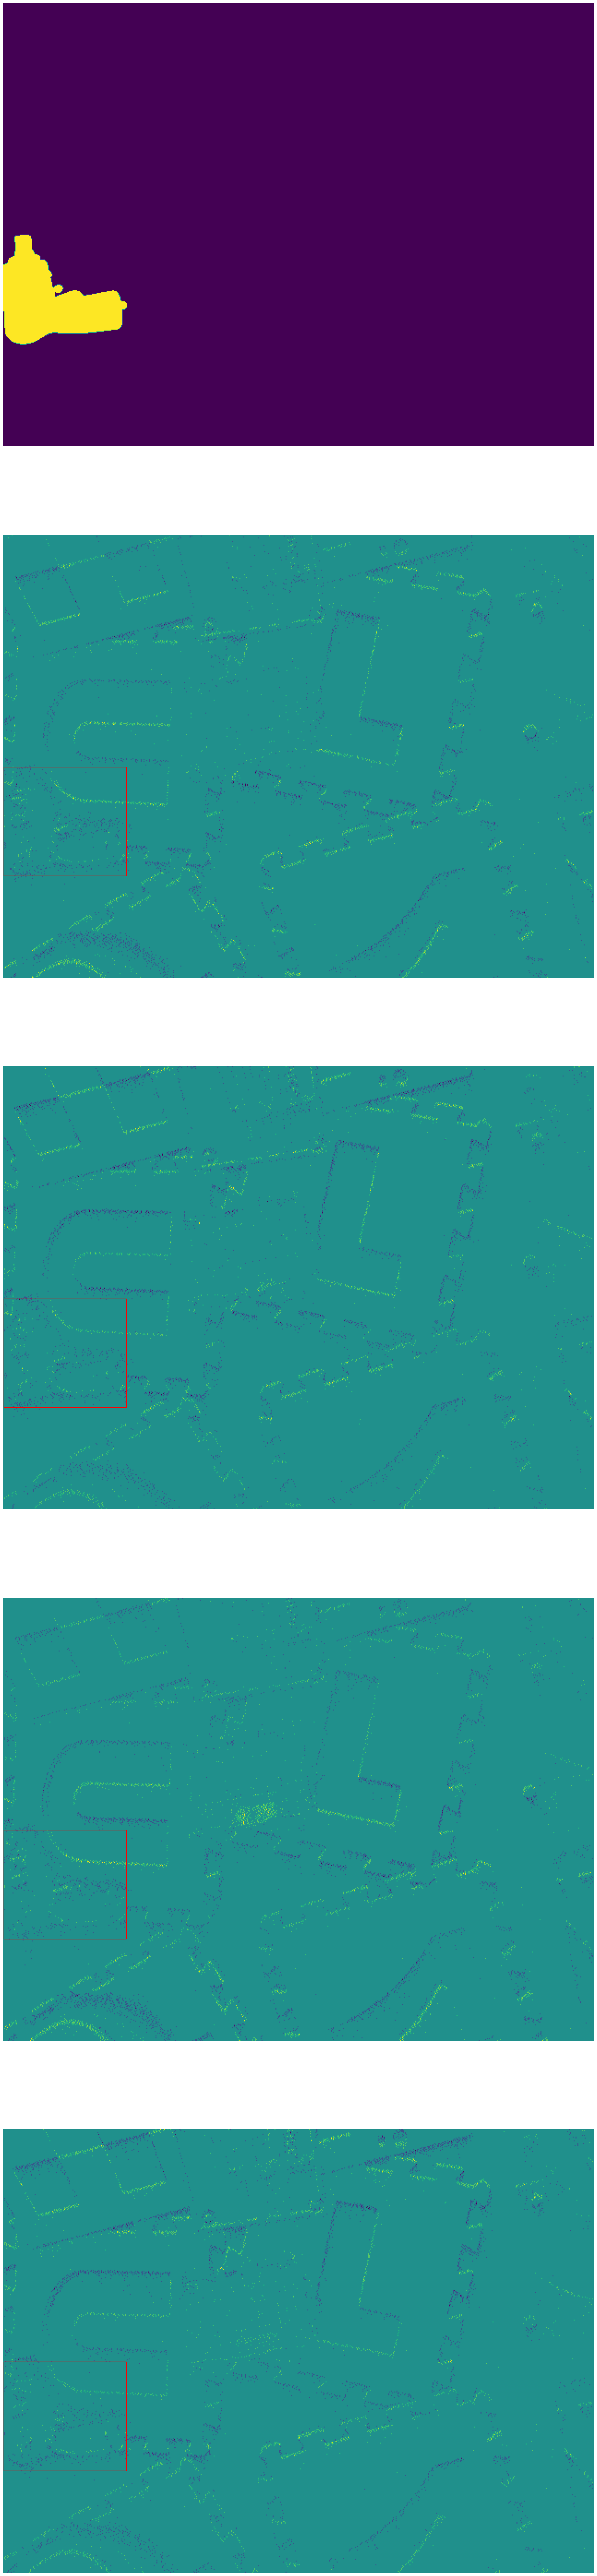

In [37]:
def plot_frame(item_to_find, frame, mask): # TODO: Put the mask processing into bounding box into the tonic dataset?
    #print(mask)

    num_bins = frame.shape[0]
    fig, ax = plt.subplots(num_bins+1, 1, figsize=(100,100))


    mask = torch.from_numpy(mask)
    obj_ids = torch.unique(mask)
    #print(obj_ids)
    obj_ids = obj_ids[1:]
    print(obj_ids)
    detection_masks = mask == obj_ids[:, None, None]
    #print(detection_masks)
    
    boxes = masks_to_boxes(detection_masks)
    print(boxes)
    #for box in boxes:
    if item_to_find in obj_ids:
        id_to_show = obj_ids.tolist().index(item_to_find)
    else:
        id_to_show = 0
    print(f"{item_to_find} index is: {id_to_show}")



    
    ax[0].imshow(detection_masks[id_to_show])
    ax[0].axis("off")


    for i, binned_events in enumerate(frame):
        img = binned_events[1] - binned_events[0]
        ax[i+1].imshow(img)

        box = boxes[id_to_show]
        ax[i+1].add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none'))
        ax[i+1].axis("off")
    
    
    


    
    print(f"obj in mask: {item_to_find in mask}")
    
    
    
    plt.show()

item_to_find = 23
frame_num = 100
plot_frame(item_to_find, tonic_dataset[frame_num]["data"], tonic_dataset.getmask(frame_num))

In [39]:
import sys
sys.path.append("./mnist_sg_cnn")

In [40]:

import utils
import snn_utils
import base_model
import lenet_decolle_model

In [41]:
import torch
import pylab as plt
device = 'cpu'

gen_train = snn_utils.get_mnist_loader(4, Nparts=100, train=True)
gen_test = snn_utils.get_mnist_loader(4, Nparts=100, train=False)

def iter_mnist(gen_train, batchsize=100, T=1000, max_rate = 20):
    datait = iter(gen_train)
    for raw_input, raw_labels in datait:
        data, labels1h = snn_utils.image2spiketrain(raw_input, raw_labels, max_duration=T, gain=max_rate) # converting data into spikes
        data_t = torch.FloatTensor(data)
        labels_t = torch.Tensor(labels1h)
        yield data_t, labels_t

T = 16 #duration of sequence
data, target = next(iter_mnist(gen_train, T=T))


data_d = data.to(device)
target_d = target.to(device)

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 45527149.10it/s]


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 52990242.27it/s]


Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 16016126.14it/s]


Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 8137773.93it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



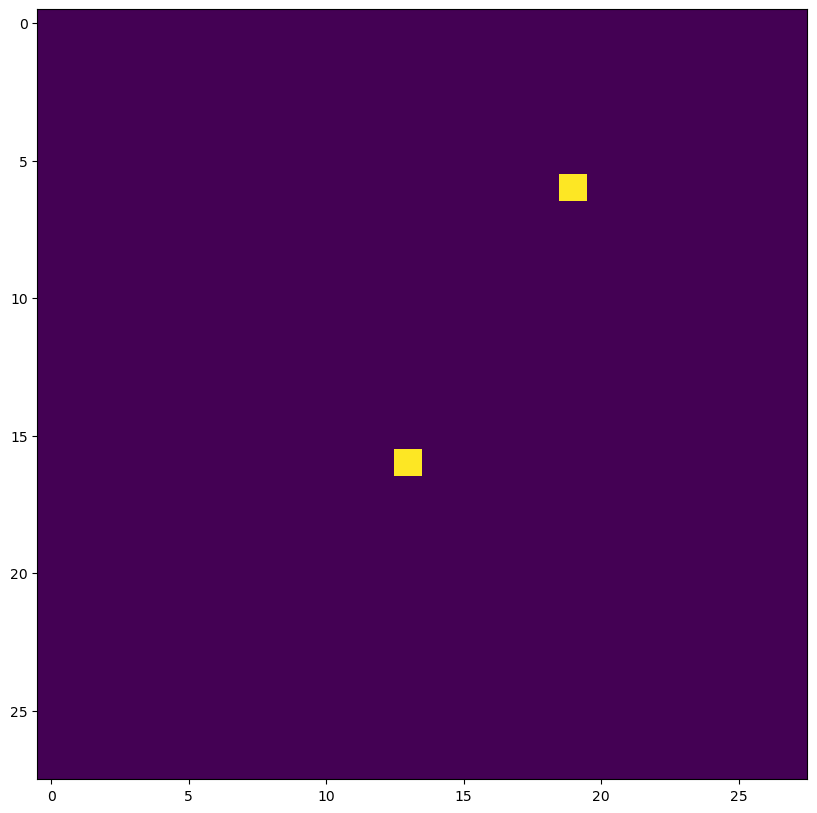

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
img = data_d[0][0][0]
ax.imshow(img)

In [53]:
data_d.shape

torch.Size([16, 4, 1, 28, 28])

In [51]:
data_d[0][0][0].unique()

tensor([0., 1.])

In [52]:
(data_d[0][0][0]==1).nonzero()

tensor([[ 6, 19],
        [16, 13]])

In [56]:
tonic_dataset[frame_num]["data"].shape

(4, 2, 480, 640)

In [59]:
torch.from_numpy(tonic_dataset[frame_num]["data"][0]).unique()

tensor([0, 1, 2], dtype=torch.int16)

In [60]:
(torch.from_numpy(tonic_dataset[frame_num]["data"][0])==2).nonzero()

tensor([[  0,  38,  54],
        [  0,  39,  45],
        [  0,  39, 401],
        [  0,  46,  14],
        [  0,  50, 174],
        [  0,  72,  78],
        [  0,  84, 374],
        [  0,  85, 378],
        [  0,  86, 525],
        [  0,  87, 384],
        [  0,  88, 385],
        [  0,  90, 400],
        [  0,  90, 521],
        [  0,  96, 179],
        [  0,  97, 174],
        [  0,  97, 176],
        [  0, 102, 226],
        [  0, 104, 502],
        [  0, 106, 136],
        [  0, 106, 356],
        [  0, 110, 120],
        [  0, 110, 125],
        [  0, 111, 258],
        [  0, 111, 261],
        [  0, 116, 520],
        [  0, 197,  11],
        [  0, 197, 387],
        [  0, 199, 392],
        [  0, 206, 426],
        [  0, 217, 576],
        [  0, 234, 488],
        [  0, 237,  83],
        [  0, 257, 273],
        [  0, 259, 289],
        [  0, 260, 291],
        [  0, 261, 295],
        [  0, 267, 249],
        [  0, 268, 249],
        [  0, 268, 321],
        [  0, 270,  14],
